<a href="https://colab.research.google.com/github/Cp557/hurricane_survival_prediction/blob/main/hurricane_survival_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, RocCurveDisplay, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Coding/hurricane_survival_prediction/World_MO_Hurricane_Survival.csv' #replace with path
dataset = pd.read_csv(dataset_path, delimiter=',')

In [ ]:
dataset.columns

Index(['ID', 'DOB', 'M_STATUS', 'SALARY', 'EDU_DATA', 'EMP_DATA', 'REL_ORIEN',
       'FAV_TV', 'PREF_CAR', 'GENDER', 'FAV_CUIS', 'FAV_MUSIC', 'ENDU_LEVEL',
       'FAV_SPORT', 'FAV_COLR', 'NEWS_SOURCE', 'DIST_FRM_COAST',
       'MNTLY_TRAVEL', 'GEN_MOVIES', 'FAV_SUBJ', 'ALCOHOL', 'FAV_SUPERHERO',
       'Dist_Coast', 'Class'],
      dtype='object')

In [ ]:
df = dataset[["DOB","M_STATUS", "SALARY", "EDU_DATA", "EMP_DATA", "GENDER", "NEWS_SOURCE", "DIST_FRM_COAST", "Class"]]
df = df.dropna()

label_encoder = LabelEncoder()

#########################################################
df["DOB"] = pd.to_datetime(df["DOB"])
current_date = pd.to_datetime('now')
df['DOB'] = current_date.year - df['DOB'].dt.year
df = df.rename(columns={'DOB': 'AGE'})

#########################################################
vec = label_encoder.fit_transform(df["M_STATUS"])
vec = tf.keras.utils.to_categorical(vec)
df["MARRIED"] = vec[:, 1:2]
df["UNMARRIED"] = vec[:, 2:]
df["DIVORCED"] = vec[:, 0:1]


#########################################################
replacement_dict = {
    '0-100K': 100000,
    '100k-300k': 300000,
    '300k-500k': 500000,
    '500k-700k': 700000,
    '700k-1 Million': 1000000,
    '1M-2Million' : 2000000
}

df["SALARY"] = df["SALARY"].replace(replacement_dict)

#########################################################
label_encoder = LabelEncoder()
vec6 = label_encoder.fit_transform(df["EMP_DATA"])
vec6 = tf.keras.utils.to_categorical(vec6)
df["EMP_DATA_Employed"] = vec6[:,0:1]
df["EMP_DATA_Self_Employed"] = vec6[:,1]
df["EMP_DATA_Unemployed"] = vec6[:, 2]

#########################################################

replacement_dict = {
    '10-25 KM': 25,
    '60-80 KM': 80,
    '0-10 KM': 10,
    '25-40 KM': 40,
    '40-60 KM': 60
}
df["DIST_FRM_COAST"] = df["DIST_FRM_COAST"].replace(replacement_dict)

#########################################################
vec_gender = label_encoder.fit_transform(df["GENDER"])
vec_gender = tf.keras.utils.to_categorical(vec_gender)
df["FEMALE"] = vec_gender[:,0]
df["MALE"] = vec_gender[:, 1]
df["NONBINARY"] = vec_gender[:,2]

#########################################################
vec_ed = label_encoder.fit_transform(df["EDU_DATA"])
vec_ed = tf.keras.utils.to_categorical(vec_ed)
df["Graduate"] = vec_ed[:, 0]
df["High-School"] = vec_ed[:,1]
df["Post-Graduate"] = vec_ed[:,2]
df["Uneducated"] = vec_ed[:,3]

#########################################################
vec_news = label_encoder.fit_transform(df["NEWS_SOURCE"])
vec_news = tf.keras.utils.to_categorical(vec_news)
df["Associated Press"] = vec_news[:,0]
df["BBC"] = vec_news[:,1]
df["CNN"] = vec_news[:,2]
df["Fox News"] = vec_news[:,3]
df["Huffington Post"] = vec_news[:,4]
df["MSN"] = vec_news[:,5]
df["New York Times"] = vec_news[:,6]
df["Reuters"] = vec_news[:,7]
#########################################################
replacement_dict = {
    'x': 1,
    'y': 0
}

df["Class"] = df["Class"].replace(replacement_dict)
#########################################################




df = df.drop(['M_STATUS', 'GENDER', 'EMP_DATA', 'EDU_DATA', 'NEWS_SOURCE'], axis=1)


desired_column_order = [col for col in df.columns if col != 'Class'] + ['Class']
df = df[desired_column_order]


print(df)


      AGE  SALARY  DIST_FRM_COAST  MARRIED  UNMARRIED  DIVORCED  \
0      59  100000              25      1.0        0.0       0.0   
1      42  500000              80      0.0        1.0       0.0   
2      45  300000              25      1.0        0.0       0.0   
3      45  500000              10      0.0        1.0       0.0   
4      55  700000              25      0.0        1.0       0.0   
...   ...     ...             ...      ...        ...       ...   
5014   61  700000              80      1.0        0.0       0.0   
5015   41  500000              80      0.0        1.0       0.0   
5016   51  300000              10      1.0        0.0       0.0   
5017   51  300000              10      1.0        0.0       0.0   
5018   51  100000              60      1.0        0.0       0.0   

      EMP_DATA_Employed  EMP_DATA_Self_Employed  EMP_DATA_Unemployed  FEMALE  \
0                   0.0                     0.0                  1.0     0.0   
1                   1.0            

<ipython-input-4-9746a689977c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DOB"] = pd.to_datetime(df["DOB"])
<ipython-input-4-9746a689977c>:8: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  current_date = pd.to_datetime('now')
<ipython-input-4-9746a689977c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOB'] = current_date.year - df['DOB'].dt.year


In [ ]:
# Partition the data
X = df.iloc[:,0:-1]
Y = df.iloc[:,-1]
#X = pd.concat((df.iloc[:,0:-1],df.iloc[:,0:-1],df.iloc[:,0:-1], df.iloc[:,0:-1], df.iloc[:,0:-1]))
#Y = pd.concat((df.iloc[:,-1],df.iloc[:,-1],df.iloc[:,-1], df.iloc[:,-1], df.iloc[:,-1]))

seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, shuffle=True, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5, shuffle=True, random_state=seed)

In [ ]:
# Use L1-based feature selection
lsvc = LinearSVC(C=.02, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_train)
X_new.shape

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(3719, 7)

In [ ]:
# See which feature vectors were kept
feature_idx = model.get_support()
X.iloc[:,feature_idx]

,AGE,DIST_FRM_COAST,UNMARRIED,EMP_DATA_Employed,Associated Press,New York Times,Reuters
0,59,25,0.0,0.0,0.0,1.0,0.0
1,42,80,1.0,1.0,1.0,0.0,0.0
2,45,25,0.0,1.0,0.0,0.0,0.0
3,45,10,1.0,1.0,0.0,0.0,0.0
4,55,25,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
5014,61,80,0.0,1.0,0.0,0.0,1.0
5015,41,80,1.0,1.0,0.0,0.0,0.0
5016,51,10,0.0,1.0,1.0,0.0,0.0
5017,51,10,0.0,1.0,0.0,1.0,0.0


In [ ]:
# Only keep variables where at least half of the categories were kept
#important_vars = list(X.iloc[:,feature_idx].columns[[0,1,4,5,6]])
#important_vars.extend(["CNN", "Fox News", "Huffington Post", "MSN", "BBC"])
#print(important_vars)

#X_train = X_train[important_vars]
#X_test = X_test[important_vars]

In [ ]:
# OTHER OPTION
#Keep all variables that had a category show up as significant
important_vars = list(X.iloc[:,feature_idx])
important_vars.extend(["BBC", "CNN", "Fox News", "Huffington Post", "MSN", "EMP_DATA_Unemployed", "EMP_DATA_Self_Employed",
                      "DIVORCED", "MARRIED"])
print(important_vars)

X_train = X_train[important_vars]
X_test = X_test[important_vars]

['AGE', 'DIST_FRM_COAST', 'UNMARRIED', 'EMP_DATA_Employed', 'Associated Press', 'New York Times', 'Reuters', 'BBC', 'CNN', 'Fox News', 'Huffington Post', 'MSN', 'EMP_DATA_Unemployed', 'EMP_DATA_Self_Employed', 'DIVORCED', 'MARRIED']


In [ ]:
# Find best learning rate and estimators for XGBoost Classifier
max_accuracy = 0
best_lr = .01
best_n_estimators = 100

for learning_rate in [.003,.01,.03]:
  for n_estimators in list(range(25, 155, 25)):
    model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    if accuracy > max_accuracy:
      max_accuracy = accuracy
      best_lr = learning_rate
      best_n_estimators = n_estimators

    print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 52.58%
Accuracy: 51.45%
Accuracy: 50.97%
Accuracy: 51.45%
Accuracy: 51.13%
Accuracy: 51.13%
Accuracy: 50.97%
Accuracy: 51.29%
Accuracy: 52.10%
Accuracy: 52.10%
Accuracy: 51.77%
Accuracy: 51.61%
Accuracy: 52.10%
Accuracy: 51.29%
Accuracy: 50.16%
Accuracy: 50.65%
Accuracy: 50.48%
Accuracy: 49.68%


In [ ]:
print(best_lr, best_n_estimators)

0.003 25


In [ ]:
model_XGB = XGBClassifier(n_estimators=best_n_estimators, learning_rate=best_lr)
model_XGB.fit(X_train, y_train)

predictions_XGB = model_XGB.predict_proba(X_test)
y_pred = np.argmax(predictions_XGB, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 52.58%


In [ ]:
# Convert target class to categorical
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(3719, 2)
(620, 2)


In [ ]:
# Configure adaptive learning rates
def adapt_learning_rate(epoch):
    return .01 / (round(.6+epoch/10))

lr_scheduler = keras.callbacks.LearningRateScheduler(adapt_learning_rate)

In [ ]:
# Test model for best batch size
best_accuracy = 0
best_bs = 0

for bs in list(range(5, 26, 5)):
  model = Sequential()
  model.add(Dense(8, input_dim=len(important_vars), activation='relu'))
  model.add(Dense(4, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  model.build()

  opt = tf.keras.optimizers.SGD(learning_rate=0.01)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.fit(X_train, y_train, epochs=50, batch_size=bs, verbose=1, callbacks=[lr_scheduler])

  test_results = model.evaluate(X_test, y_test, verbose=1)
  if test_results[1] > best_accuracy:
    best_accuracy = test_results[1]
    best_bs = bs

Epoch 1/50
744/744 [==============================] - 2s 2ms/step - loss: 0.7339 - accuracy: 0.5060 - lr: 0.0100
Epoch 2/50
744/744 [==============================] - 2s 3ms/step - loss: 0.6934 - accuracy: 0.5017 - lr: 0.0100
Epoch 3/50
744/744 [==============================] - 2s 3ms/step - loss: 0.6928 - accuracy: 0.5039 - lr: 0.0100
Epoch 4/50
744/744 [==============================] - 2s 3ms/step - loss: 0.6928 - accuracy: 0.5144 - lr: 0.0100
Epoch 5/50
744/744 [==============================] - 2s 3ms/step - loss: 0.6935 - accuracy: 0.4961 - lr: 0.0100
Epoch 6/50
744/744 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.4988 - lr: 0.0100
Epoch 7/50
744/744 [==============================] - 2s 3ms/step - loss: 0.6934 - accuracy: 0.5085 - lr: 0.0100
Epoch 8/50
744/744 [==============================] - 2s 3ms/step - loss: 0.6933 - accuracy: 0.5085 - lr: 0.0100
Epoch 9/50
744/744 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5

In [ ]:
print(best_bs)

5


In [ ]:
# Create the model
model = Sequential()
model.add(Dense(8, input_dim=len(important_vars), activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.build()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 8)                 136       
                                                                 
 dense_16 (Dense)            (None, 4)                 36        
                                                                 
 dense_17 (Dense)            (None, 2)                 10        
                                                                 
Total params: 182 (728.00 Byte)
Trainable params: 182 (728.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# Configure the model and start training
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=best_bs, verbose=1, callbacks=[lr_scheduler])

Epoch 1/50
744/744 [==============================] - 4s 4ms/step - loss: 0.7407 - accuracy: 0.5087 - lr: 0.0100
Epoch 2/50
744/744 [==============================] - 3s 4ms/step - loss: 0.6934 - accuracy: 0.5079 - lr: 0.0100
Epoch 3/50
744/744 [==============================] - 5s 7ms/step - loss: 0.6933 - accuracy: 0.5026 - lr: 0.0100
Epoch 4/50
744/744 [==============================] - 3s 4ms/step - loss: 0.6934 - accuracy: 0.5095 - lr: 0.0100
Epoch 5/50
744/744 [==============================] - 1s 2ms/step - loss: 0.6930 - accuracy: 0.5039 - lr: 0.0100
Epoch 6/50
744/744 [==============================] - 1s 2ms/step - loss: 0.6935 - accuracy: 0.4993 - lr: 0.0100
Epoch 7/50
744/744 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5079 - lr: 0.0100
Epoch 8/50
744/744 [==============================] - 1s 2ms/step - loss: 0.6929 - accuracy: 0.5133 - lr: 0.0100
Epoch 9/50
744/744 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5

In [ ]:
# Test the model after training
test_results = model.evaluate(X_test, y_test, verbose=1)
predictions_MLP = model.predict(X_test)
y_classified = np.argmax(predictions_MLP, axis=1)
y_true = np.argmax(y_test, axis=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}')

20/20 [==============================] - 0s 2ms/step
Test results - Loss: 0.6926696300506592 - Accuracy: 0.5177419185638428


Text(0.5, 1.0, 'ROC Curve for XGBoost and MLP Classifiers')

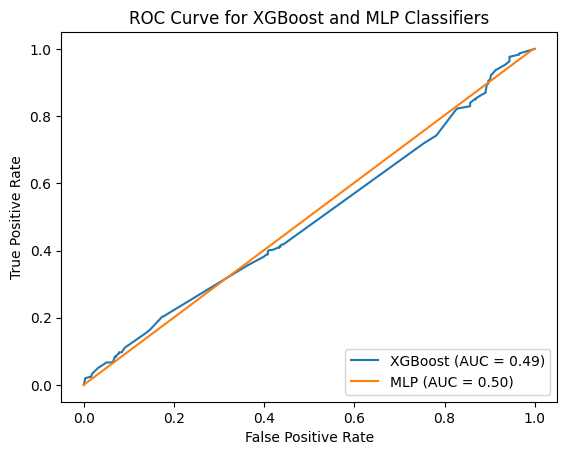

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, np.max(predictions_XGB, axis=1))
fpr2, tpr2, thresholds2 = roc_curve(y_true, np.max(predictions_MLP, axis=1))
roc_auc = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGBoost')
display.plot()
display2 = RocCurveDisplay(fpr=fpr2, tpr=tpr2, roc_auc=roc_auc2, estimator_name='MLP')
display2.plot(ax=display.ax_)
plt.title('ROC Curve for XGBoost and MLP Classifiers')